# 事前準備

In [1]:
# ライブラリのインポート
import os
import random
from glob import glob
from warnings import filterwarnings

import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

from collections import defaultdict

filterwarnings('ignore') 

In [2]:
# ランダムシードの設定
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
# デバイスの設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {} # GPUが使える場合、DataLoaderでのミニバッチの取り出しを高速化
print(f'デバイス：{device}')

デバイス：cuda


In [4]:
# 学習済み
use_pretrained = True

# Model name
model_name = 'mobilenet_v3_large'

In [5]:
# ハイパーパラメータの設定
parser = argparse.ArgumentParser()
parser.add_argument('--image_size', type=int, default=224)
parser.add_argument('--num_classes', type=int, default=2)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--lr', type=float, default=1e-4) # 学習率
parser.add_argument('--mode', type=str, default='max') # スケジューラの監視対象
parser.add_argument('--factor', type=float, default=0.5) # スケジューラの学習率を減衰させる割合
parser.add_argument('--lr_patience', type=int, default=5) # スケジューラの監視対象回数
parser.add_argument('--threshold', type=float, default=1e-5) # スケジューラの監視対象回数
parser.add_argument('--patience', type=int, default=20) # earlystoppingの監視対象回数
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=16, epochs=100, factor=0.5, image_size=224, lr=0.0001, lr_patience=5, mode='max', num_classes=2, patience=20, threshold=1e-05)


# 前処理

In [6]:
# transformの設定
transform = {
    'train': transforms.Compose([
        transforms.Resize((opt.image_size,opt.image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1.5)),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    'val': transforms.Compose([
        transforms.Resize((opt.image_size,opt.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
}

In [7]:
# ImageFolderによるデータセットの作成
train_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/train", transform=transform['train'])
val_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/val", transform=transform['val'])

In [8]:
# Dataloader
dataloader = {
    'train': DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=opt.batch_size, shuffle=False)
}

# EarlyStopping

In [9]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            self.epoch += 1 # カウンターを1増やす
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                if self.verbose: # 早期終了のフラグが1の場合
                    print('early stopping') # メッセージを出力
                return True # 学習を終了するTrueを返す
        # 前エポックの損失以下の場合
        else:
            self.epoch = 0               # カウンターを0に戻す
            self.pre_loss = current_loss # 損失の値を更新する
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

# モデルの定義

In [10]:
# 学習済みモデルの読み込み
model = models.mobilenet_v3_large(pretrained=use_pretrained)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [11]:
fc_in_features = model.classifier[0].out_features # 最終レイヤー関数の次元数
model.classifier[3] = nn.Linear(fc_in_features, opt.num_classes) # 最終レイヤー関数の付け替え
print(model)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

# Finetuning

In [12]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight", "classifier.0.bias",
                        "classifier.3.weight", "classifier.3.bias"]

# パラメータごとに各リストに格納する
for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)

params_to_update_1に格納： features.0.0.weight
params_to_update_1に格納： features.0.1.weight
params_to_update_1に格納： features.0.1.bias
params_to_update_1に格納： features.1.block.0.0.weight
params_to_update_1に格納： features.1.block.0.1.weight
params_to_update_1に格納： features.1.block.0.1.bias
params_to_update_1に格納： features.1.block.1.0.weight
params_to_update_1に格納： features.1.block.1.1.weight
params_to_update_1に格納： features.1.block.1.1.bias
params_to_update_1に格納： features.2.block.0.0.weight
params_to_update_1に格納： features.2.block.0.1.weight
params_to_update_1に格納： features.2.block.0.1.bias
params_to_update_1に格納： features.2.block.1.0.weight
params_to_update_1に格納： features.2.block.1.1.weight
params_to_update_1に格納： features.2.block.1.1.bias
params_to_update_1に格納： features.2.block.2.0.weight
params_to_update_1に格納： features.2.block.2.1.weight
params_to_update_1に格納： features.2.block.2.1.bias
params_to_update_1に格納： features.3.block.0.0.weight
params_to_update_1に格納： features.3.block.0.1.weight
params_to_update

In [13]:
# モデルをGPUに送る
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

# 学習

In [14]:
# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=opt.lr, weight_decay=0.0001)

In [15]:
# 収束が停滞したら学習率を減衰するスケジューラー
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,   # オプティマイザーを指定
    mode=opt.mode,  # 監視対象は最大値
    factor=opt.factor,  # 学習率を減衰する割合
    patience=opt.lr_patience, # 監視対象のエポック数
    min_lr=opt.threshold, # 最小学習率
    verbose=True # 学習率を減衰した場合に通知する
)

In [16]:
# 学習履歴を保存するdictオブジェクト
history = defaultdict(list)

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=opt.patience, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力

# 学習モデルの定義
def train_model(model, epochs, loss_fn, optimizer):
    
    # ベストスコアの初期化
    best_loss = np.inf
    
    # エポックループの設定
    for epoch in range(epochs):
        
        # 現在のエポック数の出力
        print(f'Epoch: {epoch+1} / {epochs}')
        print('--------------------------')
        
         # 毎エポック: 学習・検証ループの設定
        for phase in ['train', 'val']:
            
            # 学習モード、検証モードの切替
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 損失値のリセット
            epoch_loss = 0.0
            # 正解数
            corrects = 0
            # 予測値リストのリセット
            pred_list = []
            # 正解値リストのリセット
            true_list = []
            
            # dataloaderから、ミニバッチ(batch_size)単位でのデータの読み込み
            for images, labels in dataloader[phase]:
                
                # 入力データ、正解ラベルをモデルと同じdeviceへ移動
                images = images.to(device)
                labels = labels.to(device)
                
                # 勾配情報の初期化
                optimizer.zero_grad()
                
                # 学習時のみ勾配情報を有効に
                with torch.set_grad_enabled(phase=='train'):
                    
                    # モデルによる計算
                    outputs = model(images)
                    # 損失値の計算
                    loss = loss_fn(outputs, labels)
                    # 予測ラベルの算出
                    preds = torch.argmax(outputs, dim=1) # 予測値を出力
                    
                    # 学習時のみ、バックプロパゲーションとパラメータ更新
                    if phase == 'train':
                        
                        # 誤差逆伝播法により勾配の算出
                        loss.backward()
                        # optimizerのパラメータ更新
                        optimizer.step()
                    
                    # 損失値の追加
                    epoch_loss += loss.item() * images.size(0)
                    
                    # 正解数の追加
                    corrects += torch.sum(preds == labels.data)                    
                    
                    # 予測ラベルの追加
                    preds = preds.to('cpu').numpy()
                    pred_list.extend(preds)
                    
                    # 正解ラベルの追加
                    labels = labels.to('cpu').numpy()
                    true_list.extend(labels)
            
            # 1エポック内における損失値の平均
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            
            # 正解率の算出
            accuracy = corrects.double() / len(dataloader[phase].dataset)
            accuracy = accuracy.to('cpu').detach().numpy().copy()
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(accuracy)
            
            # 各評価スコアの出力
            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f}')
            
            # 検証時、検証スコアとベストスコアの大小比較を行う
            if (phase == 'val') and (epoch_loss < best_loss):
                
                ## 検証スコアが改善した場合のみ以下の処理を行う
                
                # ベストスコアの更新
                best_loss = epoch_loss
                # パラメータの名前を指定
                param_name = f'/kaggle/working/{model_name}.pth'
                # パラメータの保存
                torch.save(model.state_dict(), param_name)
        
        # スケジューラー、テストデータの精度を監視する
        scheduler.step(epoch_loss)

        # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
        if (phase == 'val') and ers(epoch_loss):
            # 監視対象のエポックで損失が改善されなければ学習を終了
            break

In [17]:
# モデルの学習と推論の実行
train_model(model, opt.epochs, criterion, optimizer)

Epoch: 1 / 100
--------------------------
train Loss: 0.1903 Accuracy: 0.9245
val Loss: 0.7240 Accuracy: 0.6875
Epoch: 2 / 100
--------------------------
train Loss: 0.1083 Accuracy: 0.9580
val Loss: 0.3601 Accuracy: 0.8125
Epoch: 3 / 100
--------------------------
train Loss: 0.0969 Accuracy: 0.9628
val Loss: 0.3644 Accuracy: 0.8125
Epoch: 4 / 100
--------------------------
train Loss: 0.0941 Accuracy: 0.9672
val Loss: 0.1251 Accuracy: 1.0000
Epoch: 5 / 100
--------------------------
train Loss: 0.0816 Accuracy: 0.9735
val Loss: 0.1112 Accuracy: 1.0000
Epoch: 6 / 100
--------------------------
train Loss: 0.0661 Accuracy: 0.9764
val Loss: 0.1105 Accuracy: 1.0000
Epoch: 7 / 100
--------------------------
train Loss: 0.0630 Accuracy: 0.9774
val Loss: 0.2719 Accuracy: 0.8750
Epoch     7: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 8 / 100
--------------------------
train Loss: 0.0571 Accuracy: 0.9789
val Loss: 0.0950 Accuracy: 0.9375
Epoch: 9 / 100
--------------------------


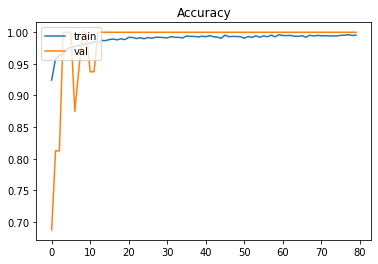

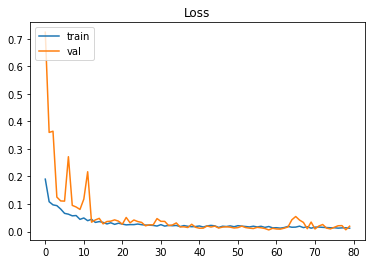

In [18]:
# 正解率の推移をプロット
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# ロスの推移をプロット
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()